3.2.9
FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: test2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/24 22:16:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/04/24 22:16:29
 Elapsed run time:  1.427 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


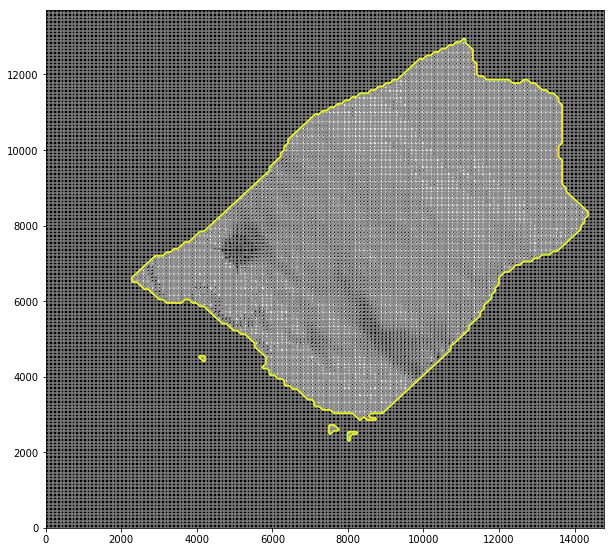

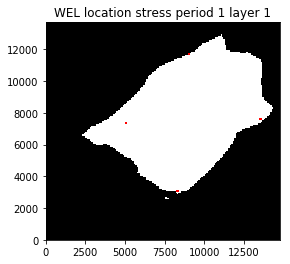

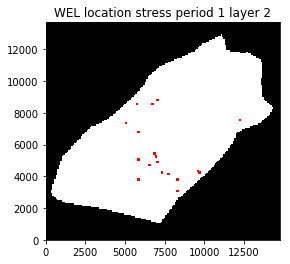

In [2]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
print(flopy.__version__)

# Assign name and create modflow model object
txtname = 'test2'
model_name = flopy.modflow.Modflow(txtname, exe_name='mf2005')

# DIS (discretization) file: spatial and temportal discretization / grid geometry
dis = flopy.modflow.ModflowDis.load('Nuuanu_v2_take3.dis', model_name)
# BAS (basic) file: cell type, initial and boundary counditions / ibounds and heads
bas = flopy.modflow.ModflowBas.load('Nuuanu_v2_take3.ba6',model_name)
# LPF (layer property flow) file: performs cell by cell flow computation
lpf = flopy.modflow.ModflowLpf.load('Nuuanu_v2_take3.lpf', model_name)
# RCH (recharge) file
rch = flopy.modflow.ModflowRch.load('Nuuanu_v2_take3.rch', model_name)
# WEL (well) file: pumping and injection wells
wel = flopy.modflow.ModflowWel.load('Nuuanu_v2_take3.wel', model_name)
# PCG (preconditioned conjugate-gradient) file: solves finite difference equations
pcg = flopy.modflow.ModflowPcg(model_name)
# HOB (head observation): brings in the coordinates of the observation wells, but not the actual observed values
hobs = flopy.modflow.ModflowHob.load('Nuuanu_v2_take3.hob',model_name)

# Add OC (output control) package to the MODFLOW model
# SPD is the stress period dictionary: used to set what output is saved for corresponding stress period and time step
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}  
oc = flopy.modflow.ModflowOc(model_name, stress_period_data=spd, compact=True)

# Write the MODFLOW model input files
model_name.write_input()

# Run the MODFLOW model
success, buff = model_name.run_model()

# Post process the results
hds = bf.HeadFile(txtname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.linspace(0, 10, 11)  # not sure about this

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# this uses modelmap to plot boundary conditions, grid, head contours, vectors
hds = bf.HeadFile(txtname + '.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 11)

cbb = bf.CellBudgetFile(txtname + '.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=model_name, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=levels)
quiver = modelmap.plot_discharge(frf, fff, head=head)
#plt.savefig('test2.png)

modelmap = flopy.plot.ModelMap(model=model_name, layer=1) # default flopy plotting function

# Plot well locations
wel.plot()

